* Ver qual é o desempenho olhando para CV HPs ou usando o HP ótimo da população
* Escolher quais vão ser os HPs ótimos usados na próxima etapa de experimentação
* Planejar o próximo batch de experimentos:
    * Todos os algortimos
    * Usar os HPs ótimos encontrados na etapa anterior
    * Rodar os algoritmos treináveis com a janela de dados completa vs janela truncada

In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import re

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
results_root_path = "../results/tsinghua_bci_lab"
script_list = os.listdir(results_root_path)

In [174]:
script_list

['StandardCCAFilter',
 'FBSpatioTemporalCCA',
 'FBSpatioTemporalCCAFilter',
 'SpatioTemporalCCA',
 'FilterbankCCA',
 'FilterbankCCAFilter',
 'StandardCCA',
 'SpatioTemporalCCAFilter']

In [175]:
all_paths = [
    os.path.join(p1, p2, p3, p4) 
        for p1 in os.listdir(results_root_path) 
        for p2 in os.listdir(os.path.join(results_root_path, p1))
        for p3 in os.listdir(os.path.join(results_root_path, p1, p2))
        for p4 in os.listdir(os.path.join(results_root_path, p1, p2, p3))
]

In [176]:
index_list = [p.split("/") for p in all_paths]
accuracy_list = [np.load(os.path.join(results_root_path, p, "accuracy.npy")) for p in all_paths]

In [177]:
experiment_results = pd.DataFrame(
    map(lambda i, a: i + list(a), index_list, accuracy_list),
    columns=["algorithm", "params", "time_params", "subject", "true_positives", "accuracy"]
)

In [178]:
experiment_results.groupby(["algorithm"]).size()

algorithm
FBSpatioTemporalCCA          1225
FBSpatioTemporalCCAFilter    1925
FilterbankCCA                 350
FilterbankCCAFilter           700
SpatioTemporalCCA            3255
SpatioTemporalCCAFilter      3955
StandardCCA                   350
StandardCCAFilter             700
dtype: int64

In [179]:
experiment_results_default = experiment_results[lambda x: x["params"].str.contains("default")]

In [180]:
experiment_results_default.groupby(["algorithm"]).size() / 350

algorithm
FBSpatioTemporalCCA          2.0
FBSpatioTemporalCCAFilter    4.0
FilterbankCCA                1.0
FilterbankCCAFilter          2.0
SpatioTemporalCCA            2.0
SpatioTemporalCCAFilter      4.0
StandardCCA                  1.0
StandardCCAFilter            2.0
dtype: float64

In [181]:
experiment_results_default.shape

(6300, 6)

In [182]:
experiment_results_default.shape

(6300, 6)

In [301]:
(experiment_results_default
 [lambda x: x["algorithm"] == "StandardCCAFilter"]
 [lambda x: x["time_params"].str.contains("_375_")]
 # [lambda x: x["subject"] == "S2"]
 .groupby("time_params")
 ["accuracy"]
 .mean()
)

time_params
125_375_125_1375     0.735476
125_375_None_None    0.719286
Name: accuracy, dtype: float64

In [183]:
grouped_results = (
    experiment_results_default
    .groupby(["algorithm", "params", "time_params"])
    ["accuracy"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .assign(stderr = lambda x: x["std"] / np.sqrt(x["count"]))
    .rename(columns={"mean": "accuracy"})
)

In [184]:
time_params_cols = [
    "start_time_idx",
    "stop_time_idx",
    "fit_start_time_idx",
    "fit_stop_time_idx"
]
grouped_results[time_params_cols] = grouped_results["time_params"].str.split("_").to_list()

In [185]:
{col: "float" for col in time_params_cols}

{'start_time_idx': 'float',
 'stop_time_idx': 'float',
 'fit_start_time_idx': 'float',
 'fit_stop_time_idx': 'float'}

In [186]:
for col in time_params_cols:
    grouped_results[col] = grouped_results[col].mask(lambda x: x == "None", "nan").astype("float")

In [192]:
grouped_results_base = grouped_results#[grouped_results.isna().any(axis=1)].copy()

In [193]:
grouped_results_base["mode"] = grouped_results_base["algorithm"].str.endswith("Filter").map({False: "correlation", True: "filter"})

In [194]:
grouped_results_base["algorithm_base"] = grouped_results_base["algorithm"].str.replace(r"Filter$", "", regex=True)

In [198]:
grouped_results_base["algorithm_name"] = grouped_results_base["algorithm_base"] + "_" + grouped_results_base["params"]
grouped_results_base["extra_fit_data"] = ~grouped_results_base["fit_stop_time_idx"].isna()

In [231]:
grouped_results_base["test"] = grouped_results_base.groupby(["mode", "start_time_idx", "extra_fit_data"], group_keys=False).apply(lambda x: x["algorithm_base"] == "StandardCCA")

In [282]:
# baseline_algorithm = "StandardCCA"
baseline_algorithm = "FilterbankCCA"
grouped_results_base["baseline_accuracy"] = (
    grouped_results_base
    .assign(baseline_accuracy = lambda x: x["accuracy"].mask(x["algorithm_base"]!=baseline_algorithm, 0.0))
    .groupby(["mode", "stop_time_idx", "extra_fit_data"])
    ["baseline_accuracy"]
    .transform(max)
)

grouped_results_base["normalized_accuracy"] = grouped_results_base["accuracy"] - grouped_results_base["baseline_accuracy"]

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


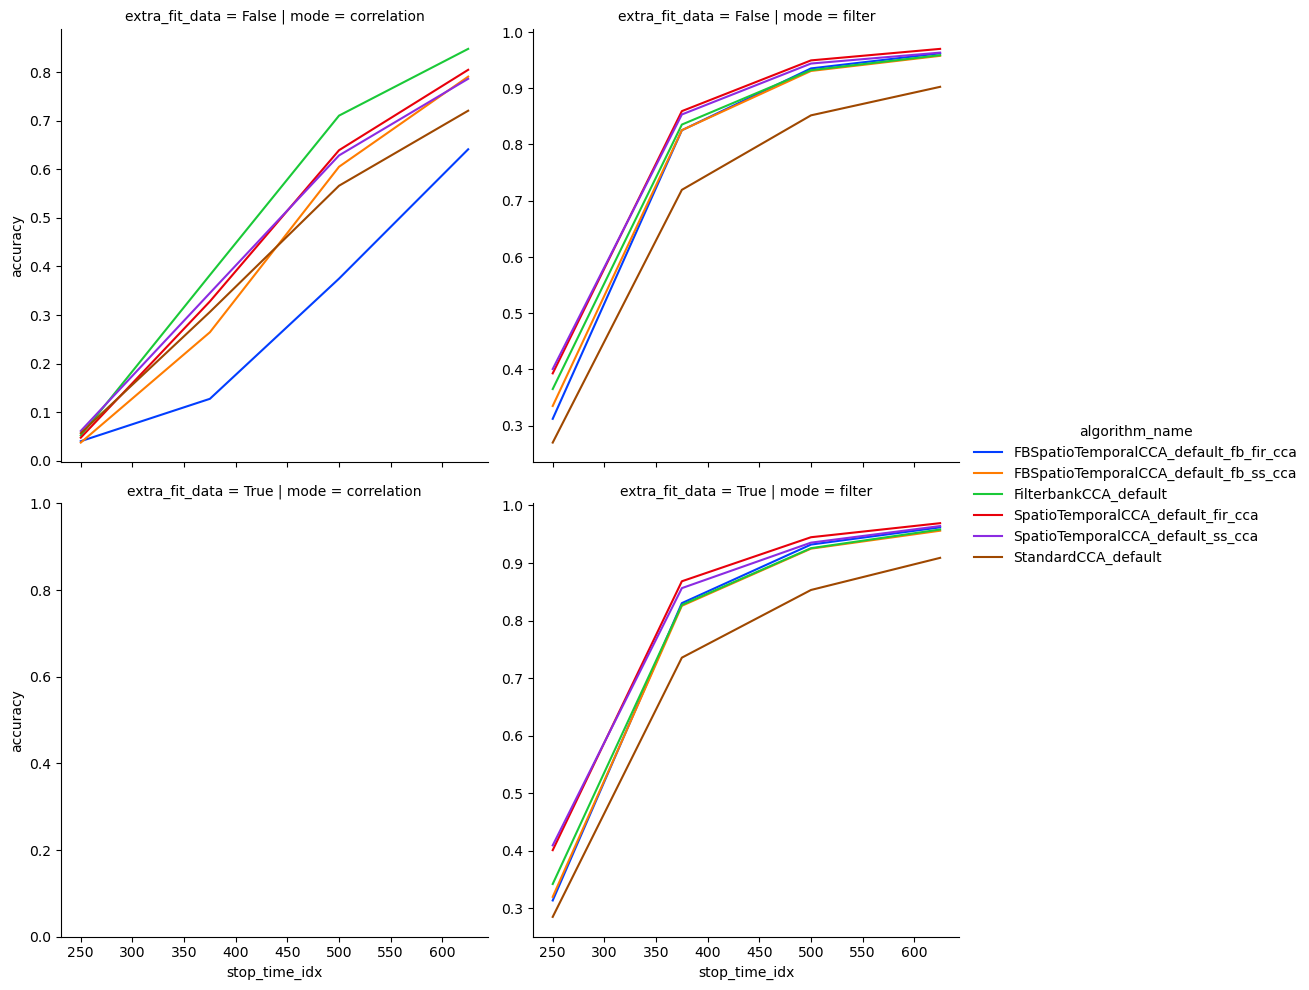

In [289]:
sns.relplot(
    data=grouped_results_base[lambda x: x["stop_time_idx"] <= 625],
    x="stop_time_idx",
    hue="algorithm_name",
    col="mode",
    row="extra_fit_data",
    y="accuracy",
    kind="line",
    facet_kws={"sharey": False},
    palette="bright"
)

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


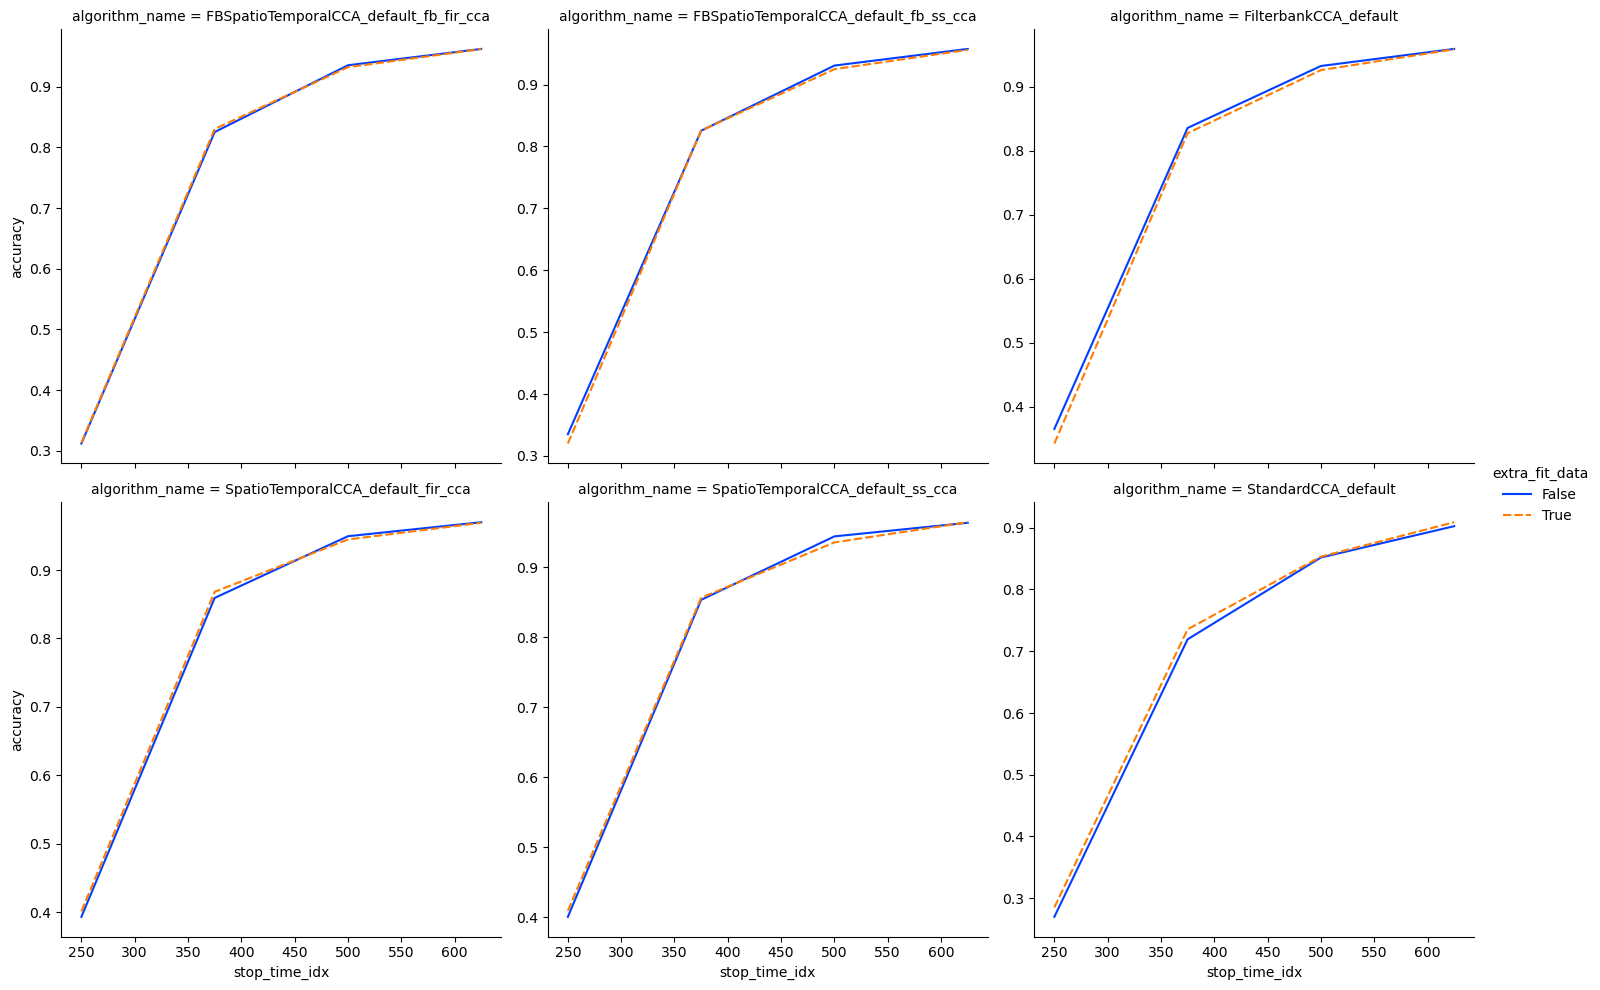

In [294]:
sns.relplot(
    data=grouped_results_base
    [lambda x: x["stop_time_idx"] <= 625]
    [lambda x: x["mode"] == "filter"],
    x="stop_time_idx",
    col="algorithm_name",
    col_wrap=3,
    hue="extra_fit_data",
    style="extra_fit_data",
    y="accuracy",
    kind="line",
    facet_kws={"sharey": False},
    palette="bright"
)

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


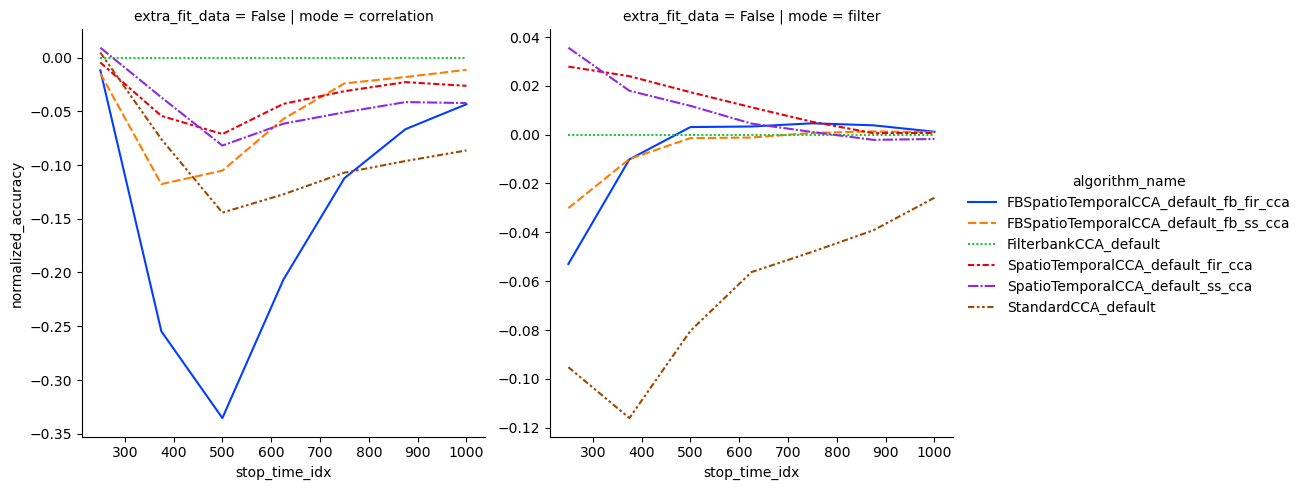

In [288]:
sns.relplot(
    data=grouped_results_base[lambda x: x["stop_time_idx"] <= 1000][lambda x: x["extra_fit_data"] == False],
    x="stop_time_idx",
    hue="algorithm_name",
    style="algorithm_name",
    col="mode",
    row="extra_fit_data",
    y="normalized_accuracy",
    kind="line",
    facet_kws={"sharey": False},
    palette="bright"
)

In [286]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
ss_fir_results = (
    experiment_results
    [lambda x: x["algorithm"].isin(["SpatioTemporalCCA", "SpatioTemporalCCAFilter"])]
    .groupby(["algorithm", "window_gap", "window_length"])
    ["accuracy"]
    .mean()
    .reset_index()
    [lambda x: x["window_length"] > 0]
)

In [60]:
fir_results = ss_fir_results[lambda x: x["window_gap"] == 0]
ss_results = ss_fir_results[lambda x: x["window_length"] == 1]

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


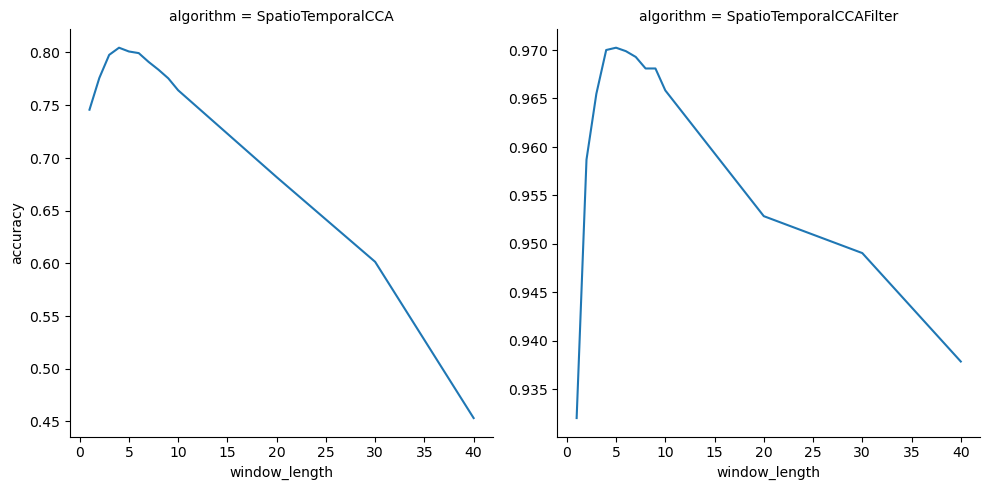

In [61]:
sns.relplot(
    fir_results,
    x="window_length",
    y="accuracy",
    col="algorithm",
    kind="line",
    facet_kws={"sharey": False}
)

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


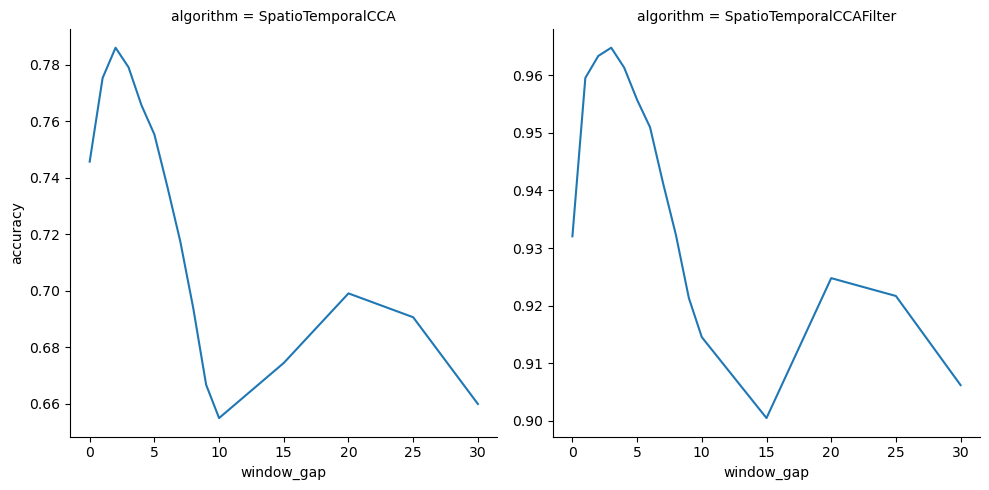

In [62]:
sns.relplot(
    ss_results,
    x="window_gap",
    y="accuracy",
    col="algorithm",
    kind="line",
    facet_kws={"sharey": False}
)

In [63]:
fir_results

,algorithm,window_gap,window_length,accuracy,std,count,stderr
1,SpatioTemporalCCA,0,1,0.745714,0.223112,35,0.037713
2,SpatioTemporalCCA,0,2,0.775833,0.205480,35,0.034732
3,SpatioTemporalCCA,0,3,0.797738,0.190752,35,0.032243
4,SpatioTemporalCCA,0,4,0.804524,0.183217,35,0.030969
5,SpatioTemporalCCA,0,5,0.800952,0.185372,35,0.031334
6,SpatioTemporalCCA,0,6,0.799405,0.184970,35,0.031266
7,SpatioTemporalCCA,0,7,0.791071,0.187301,35,0.031660
8,SpatioTemporalCCA,0,8,0.783690,0.193249,35,0.032665
9,SpatioTemporalCCA,0,9,0.775476,0.194540,35,0.032883
10,SpatioTemporalCCA,0,10,0.764167,0.196913,35,0.033284


In [64]:
ss_results

,algorithm,window_gap,window_length,accuracy,std,count,stderr
1,SpatioTemporalCCA,0,1,0.745714,0.223112,35,0.037713
14,SpatioTemporalCCA,1,1,0.775357,0.202840,35,0.034286
24,SpatioTemporalCCA,2,1,0.786071,0.196951,35,0.033291
34,SpatioTemporalCCA,3,1,0.779167,0.197712,35,0.033419
44,SpatioTemporalCCA,4,1,0.765714,0.206453,35,0.034897
54,SpatioTemporalCCA,5,1,0.755357,0.206412,35,0.034890
64,SpatioTemporalCCA,6,1,0.736905,0.214754,35,0.036300
65,SpatioTemporalCCA,7,1,0.717500,0.226700,35,0.038319
66,SpatioTemporalCCA,8,1,0.693929,0.233535,35,0.039475
67,SpatioTemporalCCA,9,1,0.666667,0.248116,35,0.041939


In [65]:
grid_seach_fir_results = ss_fir_results[
    (ss_fir_results["window_gap"] <= 5) & (ss_fir_results["window_length"] <= 10)
]

/home/cerqueirajc/miniconda3/envs/masters-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


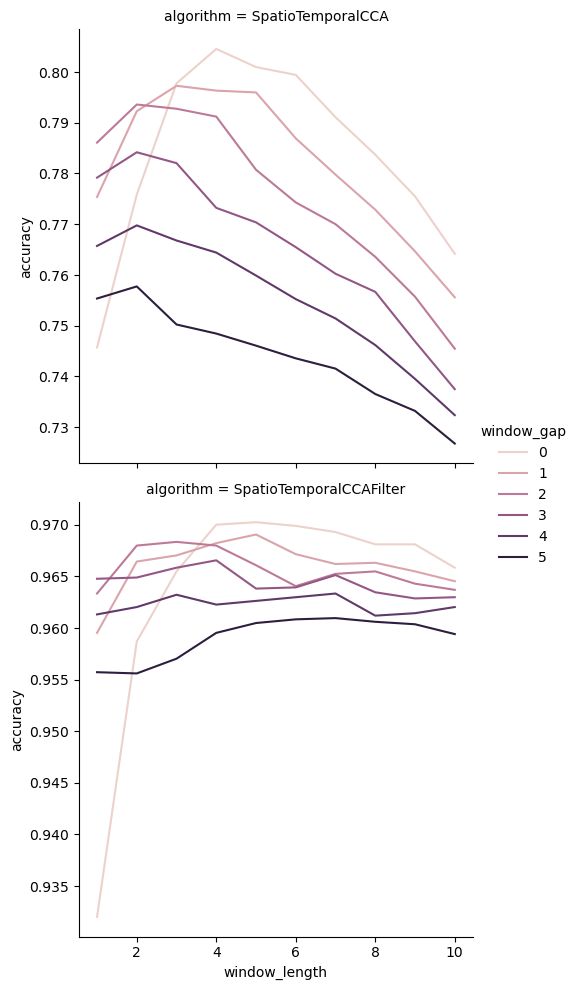

In [66]:
sns.relplot(
    data=grid_seach_fir_results,
    x="window_length",
    y="accuracy",
    hue="window_gap",
    kind="line",
    row="algorithm",
    facet_kws={"sharey": False}
)

In [67]:
grid_seach_fir_results = grid_seach_fir_results.assign(
    max_accuracy = grid_seach_fir_results.groupby("algorithm")["accuracy"].transform("max")
)

In [68]:
grid_seach_fir_results[lambda x: x["accuracy"] == x["max_accuracy"]]

,algorithm,window_gap,window_length,accuracy,std,count,stderr,max_accuracy
4,SpatioTemporalCCA,0,4,0.804524,0.183217,35,0.030969,0.804524
78,SpatioTemporalCCAFilter,0,5,0.970238,0.051312,35,0.008673,0.970238


In [73]:
grid_seach_fir_results[lambda x: x["algorithm"] == "SpatioTemporalCCAFilter"].assign(
    diff_max = lambda x: x["accuracy"] - x["max_accuracy"]
)

,algorithm,window_gap,window_length,accuracy,std,count,stderr,max_accuracy,diff_max
74,SpatioTemporalCCAFilter,0,1,0.932024,0.103802,35,0.017546,0.970238,-0.038214
75,SpatioTemporalCCAFilter,0,2,0.958690,0.061730,35,0.010434,0.970238,-0.011548
76,SpatioTemporalCCAFilter,0,3,0.965476,0.055402,35,0.009365,0.970238,-0.004762
77,SpatioTemporalCCAFilter,0,4,0.970000,0.051656,35,0.008731,0.970238,-0.000238
78,SpatioTemporalCCAFilter,0,5,0.970238,0.051312,35,0.008673,0.970238,0.000000
79,SpatioTemporalCCAFilter,0,6,0.969881,0.052248,35,0.008832,0.970238,-0.000357
80,SpatioTemporalCCAFilter,0,7,0.969286,0.053437,35,0.009032,0.970238,-0.000952
81,SpatioTemporalCCAFilter,0,8,0.968095,0.053359,35,0.009019,0.970238,-0.002143
82,SpatioTemporalCCAFilter,0,9,0.968095,0.053244,35,0.009000,0.970238,-0.002143
83,SpatioTemporalCCAFilter,0,10,0.965833,0.056707,35,0.009585,0.970238,-0.004405


In [74]:
ss_raw_res = (
    experiment_results
    [lambda x: x["algorithm"].isin(["SpatioTemporalCCA", "SpatioTemporalCCAFilter"])]
    [lambda x: x["time_params"].isin(["125_625_None_None"])]
)

In [75]:
def get_subject_hps(results, subject_num):
    subject = f"S{subject_num}"
    
    return (
        results
        [lambda x: x["subject"] != subject]
        .groupby(["algorithm", "params"])["accuracy"]
        .mean()
        .groupby("algorithm")
        .transform("idxmax")
        .drop_duplicates()
        [0]
    )
    

In [76]:
for subject_id in range(1, 36):
    print(subject_id,
          get_subject_hps(ss_raw_res[lambda x: x["algorithm"].isin(["SpatioTemporalCCA"])], subject_id)
     )

1 ('SpatioTemporalCCA', 'G0__L4')
2 ('SpatioTemporalCCA', 'G0__L4')
3 ('SpatioTemporalCCA', 'G0__L4')
4 ('SpatioTemporalCCA', 'G0__L4')
5 ('SpatioTemporalCCA', 'G0__L4')
6 ('SpatioTemporalCCA', 'G0__L4')
7 ('SpatioTemporalCCA', 'G0__L4')
8 ('SpatioTemporalCCA', 'G0__L4')
9 ('SpatioTemporalCCA', 'G0__L4')
10 ('SpatioTemporalCCA', 'G0__L4')
11 ('SpatioTemporalCCA', 'G0__L4')
12 ('SpatioTemporalCCA', 'G0__L4')
13 ('SpatioTemporalCCA', 'G0__L4')
14 ('SpatioTemporalCCA', 'G0__L4')
15 ('SpatioTemporalCCA', 'G0__L4')
16 ('SpatioTemporalCCA', 'G0__L4')
17 ('SpatioTemporalCCA', 'G0__L4')
18 ('SpatioTemporalCCA', 'G0__L4')
19 ('SpatioTemporalCCA', 'G0__L4')
20 ('SpatioTemporalCCA', 'G0__L4')
21 ('SpatioTemporalCCA', 'G0__L4')
22 ('SpatioTemporalCCA', 'G0__L4')
23 ('SpatioTemporalCCA', 'G0__L4')
24 ('SpatioTemporalCCA', 'G0__L4')
25 ('SpatioTemporalCCA', 'G0__L4')
26 ('SpatioTemporalCCA', 'G0__L4')
27 ('SpatioTemporalCCA', 'G0__L4')
28 ('SpatioTemporalCCA', 'G0__L4')
29 ('SpatioTemporalCCA', 'G0_

In [77]:
for subject_id in range(1, 36):
    print(subject_id,
          get_subject_hps(ss_raw_res[lambda x: x["algorithm"].isin(["SpatioTemporalCCAFilter"])], subject_id)
     )

1 ('SpatioTemporalCCAFilter', 'G0__L4')
2 ('SpatioTemporalCCAFilter', 'G0__L5')
3 ('SpatioTemporalCCAFilter', 'G0__L5')
4 ('SpatioTemporalCCAFilter', 'G0__L5')
5 ('SpatioTemporalCCAFilter', 'G0__L5')
6 ('SpatioTemporalCCAFilter', 'G0__L4')
7 ('SpatioTemporalCCAFilter', 'G0__L5')
8 ('SpatioTemporalCCAFilter', 'G0__L5')
9 ('SpatioTemporalCCAFilter', 'G0__L5')
10 ('SpatioTemporalCCAFilter', 'G0__L5')
11 ('SpatioTemporalCCAFilter', 'G0__L5')
12 ('SpatioTemporalCCAFilter', 'G0__L5')
13 ('SpatioTemporalCCAFilter', 'G0__L5')
14 ('SpatioTemporalCCAFilter', 'G0__L5')
15 ('SpatioTemporalCCAFilter', 'G0__L6')
16 ('SpatioTemporalCCAFilter', 'G0__L5')
17 ('SpatioTemporalCCAFilter', 'G0__L5')
18 ('SpatioTemporalCCAFilter', 'G0__L5')
19 ('SpatioTemporalCCAFilter', 'G0__L4')
20 ('SpatioTemporalCCAFilter', 'G0__L5')
21 ('SpatioTemporalCCAFilter', 'G0__L5')
22 ('SpatioTemporalCCAFilter', 'G0__L5')
23 ('SpatioTemporalCCAFilter', 'G0__L5')
24 ('SpatioTemporalCCAFilter', 'G0__L5')
25 ('SpatioTemporalCCAFil

In [81]:
ss_len_1_only = (
    ss_raw_res
    [lambda x: x["algorithm"].isin(["SpatioTemporalCCA"])]
    [lambda x: x["window_length"] == 1]
)

for subject_id in range(1, 36):
    print(subject_id,
          get_subject_hps(ss_len_1_only, subject_id)
     )

1 ('SpatioTemporalCCA', 'G2__L1')
2 ('SpatioTemporalCCA', 'G2__L1')
3 ('SpatioTemporalCCA', 'G2__L1')
4 ('SpatioTemporalCCA', 'G2__L1')
5 ('SpatioTemporalCCA', 'G2__L1')
6 ('SpatioTemporalCCA', 'G2__L1')
7 ('SpatioTemporalCCA', 'G2__L1')
8 ('SpatioTemporalCCA', 'G2__L1')
9 ('SpatioTemporalCCA', 'G2__L1')
10 ('SpatioTemporalCCA', 'G2__L1')
11 ('SpatioTemporalCCA', 'G2__L1')
12 ('SpatioTemporalCCA', 'G2__L1')
13 ('SpatioTemporalCCA', 'G2__L1')
14 ('SpatioTemporalCCA', 'G2__L1')
15 ('SpatioTemporalCCA', 'G2__L1')
16 ('SpatioTemporalCCA', 'G2__L1')
17 ('SpatioTemporalCCA', 'G2__L1')
18 ('SpatioTemporalCCA', 'G2__L1')
19 ('SpatioTemporalCCA', 'G2__L1')
20 ('SpatioTemporalCCA', 'G2__L1')
21 ('SpatioTemporalCCA', 'G2__L1')
22 ('SpatioTemporalCCA', 'G2__L1')
23 ('SpatioTemporalCCA', 'G2__L1')
24 ('SpatioTemporalCCA', 'G2__L1')
25 ('SpatioTemporalCCA', 'G2__L1')
26 ('SpatioTemporalCCA', 'G2__L1')
27 ('SpatioTemporalCCA', 'G2__L1')
28 ('SpatioTemporalCCA', 'G2__L1')
29 ('SpatioTemporalCCA', 'G2_